In [ ]:
# @title Install Dependencies
!pip install flash-attn --no-build-isolation -U bitsandbytes transformers datasets peft trl accelerate packaging ninja sentencepiece

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.4/8.4 MB 26.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.2/42.2 kB 3.4 MB/s eta 0:00:00
  Using cached ninja-1.13.0-py3-none-manylinux2014_x86_64.manylinux_2_17_x86_64.whl.metadata (5.1 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.3/61.3 MB 32.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.6/11.6 MB 125.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 544.8/544.8 kB 41.3 MB/s eta 0:00:00
Using cached ninja-1.13.0-py3-none-manylinux2014_x86_64.manylinux_2_17_x86_64.whl (180 kB)
  Created wheel for flash-attn: filename=flash_attn-2.8.3-cp312-cp312-linux_x86_64.whl size=256040057 sha256=f25da18657a87fc83dc1bfb8b7751b82246e9db355510226b674fd437c34b5fb
  Stored in directory: /root/.cache/pip/wheels/3d/59/46/f282c12c73dd4bb3c2e3fe199f1a0d0f8cec06df0cccfeee27
Successfully built flash-attn
  Attempting uninstall: transformers
    Found existing 

In [ ]:

import torch
import gc

def check_gpu_setup():
    if torch.cuda.is_available():
        gpu_name = torch.cuda.get_device_name(0)
        total_memory = torch.cuda.get_device_properties(0).total_memory / 1024**3
        print(f" GPU Available: {gpu_name}")
        print(f" Total GPU Memory: {total_memory:.2f} GB")
        print(f" CUDA Version: {torch.version.cuda}")

        # Clear any existing GPU memory
        torch.cuda.empty_cache()
        gc.collect()

        allocated = torch.cuda.memory_allocated() / 1024**3
        print(f" Currently Allocated: {allocated:.2f} GB")
        return True
    else:
        print(" No GPU available! Please enable GPU in Runtime  or Change runtime type")
        return False

gpu_available = check_gpu_setup()


 GPU Available: NVIDIA A100-SXM4-80GB
 Total GPU Memory: 79.32 GB
 CUDA Version: 12.6
 Currently Allocated: 0.00 GB


In [ ]:

# @title Mount Google Drive
# @markdown Mount Google Drive to access your datasets or save models

from google.colab import drive

try:
    drive.mount('/content/drive')
    print(" Google Drive mounted successfully!")
except Exception as e:
    print(f" Could not mount Google Drive: {e}")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
 Google Drive mounted successfully!


In [ ]:
from huggingface_hub import login
login()

In [ ]:
# @title Import Libraries
import random
import gc
import os
import torch
from datasets import load_dataset, Dataset
from transformers import (
    AutoModelForCausalLM,
    AutoTokenizer,
    BitsAndBytesConfig,
    HfArgumentParser,
    TrainingArguments,
    pipeline,
    logging,
    TrainerCallback,
    EarlyStoppingCallback
)
from peft import LoraConfig, PeftModel
from peft import LoraConfig, prepare_model_for_kbit_training, get_peft_model
from trl import SFTTrainer
import numpy as np
import pandas as pd
import transformers
import accelerate
import bitsandbytes as bnb
from datasets import load_dataset, concatenate_datasets
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
import json
from datetime import datetime

# Set up plotting style
plt.style.use('default')
sns.set_palette("husl")

In [ ]:
# @title Configuration and Parameters

# File paths
INPUT_FILE = "/content/drive/MyDrive/research/data/therapy_dataset.csv"
OUTPUT_DIR = "/content/drive/MyDrive/research/mindspace"
MODEL_NAME = "meta-llama/Llama-2-7b-chat-hf"
HF_TOKEN = ""

# Training parameters
TRAIN_SPLIT = 0.7
VAL_SPLIT = 0.15
TEST_SPLIT = 0.15
MAX_SEQ_LENGTH = 2048
NUM_EPOCHS = 15
BATCH_SIZE = 6

# Learning rate
LEARNING_RATE = 3e-5  # Between your 5e-5 and 1e-5
WARMUP_RATIO = 0.05
LR_SCHEDULER_TYPE = "cosine"
WEIGHT_DECAY = 0.001

# LoRA Configuration
LORA_R = 32
LORA_ALPHA = 64
LORA_DROPOUT = 0.1
LORA_TARGET_MODULES = ["q_proj", "v_proj", "k_proj", "o_proj", "gate_proj", "up_proj", "down_proj"]

# Early Stopping
EARLY_STOPPING_PATIENCE = 8
EARLY_STOPPING_THRESHOLD = 0.005
OVERFITTING_THRESHOLD = 0.2
ENABLE_EARLY_STOPPING = True
ENABLE_OVERFITTING_STOP = True

# Training Configuration
GRADIENT_ACCUMULATION_STEPS = 4
MAX_GRAD_NORM = 1.0
EVAL_STEPS = 50
LOGGING_STEPS = 25
SAVE_STEPS = 50

In [ ]:
# @title Quantization Configuration

nf4_config = BitsAndBytesConfig(
   load_in_4bit=True,
   bnb_4bit_quant_type="nf4",
   bnb_4bit_use_double_quant=True,
   bnb_4bit_compute_dtype=torch.bfloat16
)

In [ ]:
# @title Data Loading and Preprocessing Functions

def load_and_split_data(file_path):
    """Load dataset and split into train/val/test"""
    print("Loading dataset...")

    if file_path.endswith('.csv'):
        df = pd.read_csv(file_path)
    elif file_path.endswith('.json'):
        df = pd.read_json(file_path)
    else:
        raise ValueError("Unsupported file format. Use CSV or JSON.")

    print(f"Dataset loaded with {len(df)} samples")
    print(f"Columns: {df.columns.tolist()}")

    # Display first few rows to understand data structure
    print("\nFirst 3 rows of data:")
    print(df.head(3))

    # Split the data
    train_df, temp_df = train_test_split(df, test_size=(1-TRAIN_SPLIT), random_state=42)
    val_df, test_df = train_test_split(temp_df, test_size=(TEST_SPLIT/(VAL_SPLIT+TEST_SPLIT)), random_state=42)

    print(f"Train samples: {len(train_df)}")
    print(f"Validation samples: {len(val_df)}")
    print(f"Test samples: {len(test_df)}")

    # Convert to HuggingFace datasets
    train_dataset = Dataset.from_pandas(train_df)
    val_dataset = Dataset.from_pandas(val_df)
    test_dataset = Dataset.from_pandas(test_df)

    return train_dataset, val_dataset, test_dataset

In [ ]:
# @title Model and Tokenizer Setup

def setup_model_and_tokenizer():
    """Initialize model and tokenizer with LoRA configuration"""
    print("Loading tokenizer...")
    tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME, token=HF_TOKEN)
    tokenizer.pad_token = tokenizer.eos_token
    tokenizer.padding_side = "right"

    print("Loading model...")
    model = transformers.AutoModelForCausalLM.from_pretrained(
        MODEL_NAME,
        token=HF_TOKEN,
        quantization_config=nf4_config,
        torch_dtype=torch.bfloat16,
        device_map="auto"
    )

    try:
        if hasattr(model.config, 'attn_implementation'):
            model.config.attn_implementation = "flash_attention_2"
            print("Flash Attention 2 enabled successfully")
    except Exception as e:
        print(f"Flash Attention 2 not available: {e}")

    # LoRA config with target modules
    peft_config = LoraConfig(
        r=LORA_R,
        lora_alpha=LORA_ALPHA,
        lora_dropout=LORA_DROPOUT,
        bias="none",
        task_type="CAUSAL_LM",
        target_modules=LORA_TARGET_MODULES,
        fan_in_fan_out=False,
        inference_mode=False,  # Training mode
    )

    print(f" Enhanced LoRA Configuration:")
    print(f"   - Rank (r): {LORA_R}")
    print(f"   - Alpha: {LORA_ALPHA}")
    print(f"   - Dropout: {LORA_DROPOUT}")
    print(f"   - Target modules: {LORA_TARGET_MODULES}")

    # Prepare model for training
    model = prepare_model_for_kbit_training(model)
    model = get_peft_model(model, peft_config)

    # Print trainable parameters
    model.print_trainable_parameters()

    return model, tokenizer, peft_config

In [ ]:
# @title Data Formatting Functions

# System message
system_message = """You are a helpful and truthful psychology and psychotherapy assistant. Your primary role is to provide empathetic, understanding, and non-judgmental responses to users seeking emotional and psychological support.
Always respond with empathy and demonstrate active listening; try to focus on the user. Your responses should reflect that you understand the user's feelings and concerns. If a user expresses thoughts of self-harm, suicide, or harm to others, prioritize their safety.
Encourage them to seek immediate professional help and provide emergency contact numbers when appropriate. You are not a licensed medical professional. Do not diagnose or prescribe treatments.
Instead, encourage users to consult with a licensed therapist or medical professional for specific advice. Avoid taking sides or expressing personal opinions. Your role is to provide a safe space for users to share and reflect.
Remember, your goal is to provide a supportive and understanding environment for users to share their feelings and concerns. Always prioritize their well-being and safety."""

def format_llama(entry):
    """Format data for LLaMA chat format"""
    try:
        # promt format for fine-tuned model evaluation
        formatted = f"<s>[INST] <<SYS>>{system_message}<</SYS>>Context: {entry['context']}\n\nResponse: [/INST] {entry['response']} </s>"
        return formatted
    except KeyError:
        # Fallback: try to detect column names
        available_keys = list(entry.keys())
        print(f"'context'/'response' not found. Available keys: {available_keys}")

        context_key = None
        response_key = None

        for key in ['Context', 'context', 'input', 'Input', 'question', 'Question', 'prompt', 'Prompt']:
            if key in entry:
                context_key = key
                break

        for key in ['response', 'response', 'output', 'Output', 'answer', 'Answer', 'reply', 'Reply']:
            if key in entry:
                response_key = key
                break

        if context_key and response_key:
            formatted = f"<s>[INST] <<SYS>>{system_message}<</SYS>>{entry[context_key]} [/INST] {entry[response_key]} </s>"
            return formatted
        else:
            raise ValueError(f"Could not find appropriate input/output columns. Available keys: {available_keys}")


In [ ]:
# @title Advanced Early Stopping Callback

class AdvancedEarlyStoppingCallback(TrainerCallback):
    """
    Advanced Early Stopping Callback with multiple criteria
    """

    def __init__(self,
                 early_stopping_patience=2,
                 early_stopping_threshold=0.005,
                 overfitting_threshold=OVERFITTING_THRESHOLD,
                 enable_overfitting_stop=True):
        self.early_stopping_patience = early_stopping_patience
        self.early_stopping_threshold = early_stopping_threshold
        self.overfitting_threshold = overfitting_threshold
        self.enable_overfitting_stop = enable_overfitting_stop

        # Tracking variables
        self.best_val_loss = float('inf')
        self.patience_counter = 0
        self.val_losses = []
        self.train_losses = []
        self.steps = []
        self.stop_reason = None
        self.should_stop = False

        # Track patience history for visualization
        self.patience_history = []


    def on_evaluate(self, args, state, control, model=None, logs=None, **kwargs):
        # Check trainer state for evaluation data
        if hasattr(state, 'log_history') and state.log_history:
            print(f"   - Log history length: {len(state.log_history)}")
            # Check last few entries for eval_loss
            for i, entry in enumerate(reversed(state.log_history[-5:])):
                print(f" - Log history[{len(state.log_history)-1-i}]: {entry}")

        # get eval_loss from logs
        current_val_loss = None
        if logs and 'eval_loss' in logs:
            current_val_loss = logs['eval_loss']
            print(f" Got val loss from logs: {current_val_loss}")

        # get eval_loss from log history
        elif hasattr(state, 'log_history') and state.log_history:
            print(f" Searching log history for eval_loss...")
            for entry in reversed(state.log_history):
                if 'eval_loss' in entry and entry.get('step') == state.global_step:
                    current_val_loss = entry['eval_loss']
                    print(f" Got val loss from history: {current_val_loss}")
                    break

        # get eval_loss from any recent entry
        if current_val_loss is None and hasattr(state, 'log_history') and state.log_history:
            print(f" Looking for ANY recent eval_loss...")
            for entry in reversed(state.log_history[-10:]):  # Check last 10 entries
                if 'eval_loss' in entry:
                    entry_step = entry.get('step', 0)
                    if abs(entry_step - state.global_step) <= 2:  # Within 2 steps
                        current_val_loss = entry['eval_loss']
                        print(f" Using recent eval_loss: {current_val_loss} (from step {entry_step})")
                        break

        if current_val_loss is None:
            return

        current_step = state.global_step
        print(f" Using val loss: {current_val_loss:.6f} at step {current_step}")

        # Get training loss
        current_train_loss = None
        if hasattr(state, 'log_history') and state.log_history:
            for entry in reversed(state.log_history):
                log_step = entry.get('step', 0)
                if log_step <= current_step and ('loss' in entry or 'train_loss' in entry):
                    current_train_loss = entry.get('train_loss', entry.get('loss'))
                    print(f"  Found train loss: {current_train_loss:.6f} (from step {log_step})")
                    break

        # Store metrics
        self.val_losses.append(current_val_loss)
        self.steps.append(current_step)
        if current_train_loss is not None:
            self.train_losses.append(current_train_loss)
        else:
            self.train_losses.append(float('nan'))
            print(f" No train loss found - using NaN")

        print(f"STORED: steps={len(self.steps)}, val_losses={len(self.val_losses)}, train_losses={len(self.train_losses)}")

        # Early stopping logic
        improvement = self.best_val_loss - current_val_loss
        print(f"Best val loss: {self.best_val_loss:.6f}, Current: {current_val_loss:.6f}, Improvement: {improvement:.6f}")

        if improvement > self.early_stopping_threshold:
            self.best_val_loss = current_val_loss
            self.patience_counter = 0
            print(f" IMPROVEMENT → Reset patience to 0")
        else:
            self.patience_counter += 1
            print(f" NO IMPROVEMENT → Patience: {self.patience_counter}/{self.early_stopping_patience}")

            if self.patience_counter >= self.early_stopping_patience:
                self.stop_reason = f"Early stopping: No improvement for {self.early_stopping_patience} evaluations"
                self.should_stop = True
                control.should_training_stop = True
                print(f" TRIGGERING EARLY STOP!")
                self.patience_history.append(self.patience_counter)
                return

        # Store patience
        self.patience_history.append(self.patience_counter)
        print(f" STORED patience: {self.patience_counter}, total history: {len(self.patience_history)}")

        # Overfitting check
        if current_train_loss is not None and not np.isnan(current_train_loss):
            gap = abs(current_train_loss - current_val_loss)
            print(f" Train-Val gap: {gap:.6f} (threshold: {self.overfitting_threshold})")
            if gap > self.overfitting_threshold and current_train_loss < current_val_loss:
                print(f" Overfitting detected!")
                self.stop_reason = f"Overfitting: gap={gap:.6f}"
                self.should_stop = True
                control.should_training_stop = True
                return

        print(f" Continue training...")


    def on_train_end(self, args, state, control, **kwargs):
        """Enhanced summary when training ends"""
        print(f"\n{'='*60}")
        if self.should_stop and self.stop_reason:
            print(f"Model Training Stopped early!")
            print(f" Reason: {self.stop_reason}")
            print(f" Best validation loss: {self.best_val_loss:.6f}")
            print(f" Final validation loss: {self.val_losses[-1] if self.val_losses else 'N/A'}")
            print(f" Training steps completed: {self.steps[-1] if self.steps else 0}")
            print(f" Time/compute saved: Significant!")
        else:
            print(f" Model Training Completed normally")
            print(f" Final validation loss: {self.val_losses[-1] if self.val_losses else 'N/A'}")
            print(f" Total steps: {self.steps[-1] if self.steps else 0}")
        print(f"{'='*60}")


In [ ]:
# @title Enhanced Metrics Callback

class EnhancedMetricsCallback(TrainerCallback):
    """Enhanced callback to capture comprehensive training metrics"""
    def __init__(self):
        self.steps = []
        self.train_losses = []
        self.val_losses = []
        self.learning_rates = []
        self.grad_norms = []
        self.last_train_loss = None
        self.last_learning_rate = None
        self.last_grad_norm = None

    def on_log(self, args, state, control, logs=None, **kwargs):
        """Capture training metrics whenever they're logged"""
        if logs:
            # Capture training loss
            train_loss = None
            for key in ['loss', 'train_loss', 'training_loss']:
                if key in logs:
                    train_loss = logs[key]
                    break

            if train_loss is not None:
                self.last_train_loss = train_loss
                # Reduced verbosity - only log occasionally
                if state.global_step % 25 == 0:
                    print(f" Train loss at step {state.global_step}: {train_loss:.6f}")

            # Capture learning rate
            if 'learning_rate' in logs:
                self.last_learning_rate = logs['learning_rate']
                self.learning_rates.append(logs['learning_rate'])

            # Capture gradient norm
            if 'grad_norm' in logs:
                self.last_grad_norm = logs['grad_norm']
                self.grad_norms.append(logs['grad_norm'])

            if state.global_step % 50 == 0:  # Every 50 steps to reduce verbosity
                print(f"🔧 Available log keys at step {state.global_step}: {list(logs.keys())}")


    def on_evaluate(self, args, state, control, logs=None, **kwargs):
        """Capture validation metrics"""
        if logs and 'eval_loss' in logs:
            step = state.global_step
            val_loss = logs['eval_loss']

            self.steps.append(step)
            self.val_losses.append(val_loss)

            # Use the last captured training loss
            if self.last_train_loss is not None:
                self.train_losses.append(self.last_train_loss)
                print(f" Step {step:3d} | Train: {self.last_train_loss:.6f} | Val: {val_loss:.6f}")
            else:
                self.train_losses.append(float('nan'))
                print(f" Step {step:3d} | Train: N/A | Val: {val_loss:.6f}")

    def on_train_begin(self, args, state, control, **kwargs):
        """Print debug info when training starts"""
        print(f"\n Enhanced training started with comprehensive metrics tracking")
        print(f"Eval steps: {args.eval_steps}")
        print(f"Logging steps: {args.logging_steps}")
        print(f"Max steps: {args.max_steps}")

In [ ]:
#@title Comprehensive Visualizations

def create_comprehensive_visualizations(trainer, callback, early_stopping_callback, save_dir):
    """Create comprehensive training visualizations with early stopping"""

    def extract_training_data(trainer):
        """Extract training data from trainer's log history"""
        steps = []
        train_losses = []
        val_losses = []

        if hasattr(trainer.state, 'log_history'):
            log_history = trainer.state.log_history

            for entry in log_history:
                if 'eval_loss' in entry:
                    step = entry.get('step', 0)
                    val_loss = entry['eval_loss']

                    train_loss = None
                    for train_entry in reversed(log_history):
                        if 'train_loss' in train_entry or 'loss' in train_entry:
                            train_step = train_entry.get('step', 0)
                            if train_step <= step:
                                train_loss = train_entry.get('train_loss', train_entry.get('loss'))
                                break

                    steps.append(int(step))
                    val_losses.append(val_loss)
                    train_losses.append(train_loss)

        return steps, train_losses, val_losses

    print("\nGenerating comprehensive visualizations with working early stopping...")

    # Use early stopping callback data if available, otherwise extract from trainer
    if early_stopping_callback.steps and early_stopping_callback.val_losses:
        print(" Using early stopping callback data")
        steps = early_stopping_callback.steps
        val_losses = early_stopping_callback.val_losses
        train_losses = early_stopping_callback.train_losses
    else:
        print(" Extracting from trainer log history")
        steps, train_losses, val_losses = extract_training_data(trainer)

    if not steps or not val_losses:
        print(" No data available for visualization")
        return [], [], []

    print(f" Creating visualizations with {len(steps)} data points")

    # Ensure train_losses has same length as val_losses
    while len(train_losses) < len(val_losses):
        train_losses.append(float('nan'))

    # Calculate additional metrics
    perplexities = [np.exp(loss) for loss in val_losses]

    # Create comprehensive visualization dashboard
    fig = plt.figure(figsize=(20, 16))

    # 1. Main Loss Plot with Early Stopping Indicator
    ax1 = plt.subplot(3, 3, 1)
    plt.plot(steps, train_losses, 'b-', label='train', linewidth=2)
    plt.plot(steps, val_losses, 'orange', label='validation', linewidth=2)

    # Mark early stopping point if applicable
    if early_stopping_callback.should_stop and steps:
        stop_step = steps[-1]
        plt.axvline(x=stop_step, color='red', linestyle='--', linewidth=2, alpha=0.7, label='Early Stop')
        plt.text(stop_step, max(max([t for t in train_losses if not np.isnan(t)], default=[0]),
                               max(val_losses)), 'STOPPED',
                rotation=90, va='top', ha='right', color='red', fontweight='bold')

    plt.xlabel('Steps')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.grid(True, alpha=0.3)

    # 2. Perplexity Plot
    ax2 = plt.subplot(3, 3, 2)
    plt.plot(steps, perplexities, 'purple', marker='o', linewidth=2, markersize=8)
    plt.xlabel('Steps')
    plt.ylabel('Perplexity')
    plt.title('Validation Perplexity')
    plt.grid(True, alpha=0.3)

    # Add perplexity value annotations
    for step, ppl in zip(steps, perplexities):
        plt.annotate(f'{ppl:.2f}', (step, ppl), textcoords="offset points",
                    xytext=(0,10), ha='center', fontsize=9, fontweight='bold')

    # Early Stopping Analysis
    ax3 = plt.subplot(3, 3, 3)
    if len(val_losses) > 1:
        improvements = []
        intervals = []
        for i in range(1, len(val_losses)):
            improvement = val_losses[i-1] - val_losses[i]
            improvements.append(improvement)
            intervals.append(f"{steps[i-1]}-{steps[i]}")

        colors = ['green' if imp > EARLY_STOPPING_THRESHOLD else 'orange' if imp > 0 else 'red' for imp in improvements]
        bars = plt.bar(range(len(improvements)), improvements, color=colors, alpha=0.7)

        # Add threshold line
        plt.axhline(y=EARLY_STOPPING_THRESHOLD, color='green', linestyle='--', alpha=0.8,
                   label=f'Improvement Threshold ({EARLY_STOPPING_THRESHOLD})')

        # Add value labels
        for i, (bar, val) in enumerate(zip(bars, improvements)):
            height = bar.get_height()
            plt.annotate(f'{val:.3f}',
                        xy=(bar.get_x() + bar.get_width() / 2, height),
                        xytext=(0, 3 if height > 0 else -15),
                        textcoords="offset points", ha='center', va='bottom',
                        fontweight='bold', fontsize=9)

        plt.xticks(range(len(intervals)), intervals, rotation=45)
        plt.ylabel('Loss Improvement')
        plt.title('Early Stopping Analysis')
        plt.legend()
        plt.axhline(y=0, color='black', linestyle='--', alpha=0.5)
    else:
        plt.text(0.5, 0.5, 'Need multiple\nevaluations', ha='center', va='center', transform=ax3.transAxes)
        plt.title('Early Stopping Analysis')
    plt.grid(True, alpha=0.3)

    #  Overfitting Monitor
    ax4 = plt.subplot(3, 3, 4)
    if len(train_losses) == len(val_losses) and len(train_losses) > 0:
        gaps = []
        for t, v in zip(train_losses, val_losses):
            if not (np.isnan(t) or np.isnan(v)):
                gaps.append(abs(float(t) - float(v)))
            else:
                gaps.append(0)  # Use 0 for missing data

        plt.plot(steps, gaps, 'red', marker='D', linewidth=2, markersize=6)

        # Add overfitting threshold line
        plt.axhline(y=OVERFITTING_THRESHOLD, color='red', linestyle='--', alpha=0.8,
                   label=f'Overfitting Threshold ({OVERFITTING_THRESHOLD})')

        plt.xlabel('Steps')
        plt.ylabel('Train-Val Loss Gap')
        plt.title('Overfitting Monitor')
        plt.legend()
        plt.grid(True, alpha=0.3)

        # Color code the danger area
        plt.fill_between(steps, gaps, OVERFITTING_THRESHOLD,
                        where=[g > OVERFITTING_THRESHOLD for g in gaps],
                        color='red', alpha=0.2, label='Overfitting Zone')

        # Add annotations for dangerous values
        for step, gap in zip(steps, gaps):
            if gap > OVERFITTING_THRESHOLD:
                plt.annotate(f'{gap:.3f}', (step, gap), textcoords="offset points",
                            xytext=(0,10), ha='center', fontsize=8, color='red', fontweight='bold')
    else:
        plt.text(0.5, 0.5, 'Train-Val data\nmismatch', ha='center', va='center', transform=ax4.transAxes)
        plt.title('Overfitting Monitor')

    # Early Stopping Patience Tracker
    ax5 = plt.subplot(3, 3, 5)
    if hasattr(early_stopping_callback, 'patience_history') and early_stopping_callback.patience_history:
        print(f" Patience tracker: Found {len(early_stopping_callback.patience_history)} patience values")

        patience_steps = early_stopping_callback.steps[:len(early_stopping_callback.patience_history)]
        patience_values = early_stopping_callback.patience_history

        plt.plot(patience_steps, patience_values, 'orange', marker='s', linewidth=2, markersize=6)
        plt.axhline(y=EARLY_STOPPING_PATIENCE, color='red', linestyle='--', alpha=0.8,
                   label=f'Max Patience ({EARLY_STOPPING_PATIENCE})')

        # Fill danger zone
        plt.fill_between(patience_steps, patience_values, EARLY_STOPPING_PATIENCE,
                        where=[p >= EARLY_STOPPING_PATIENCE for p in patience_values],
                        color='red', alpha=0.2, label='Stop Zone')

        # Add value annotations
        for step, patience in zip(patience_steps, patience_values):
            if patience > 0:  # Only annotate non-zero patience
                plt.annotate(f'{patience}', (step, patience), textcoords="offset points",
                            xytext=(0,8), ha='center', fontsize=9, fontweight='bold')

        plt.xlabel('Steps')
        plt.ylabel('Patience Counter')
        plt.title('Patience Tracker')
        plt.legend()
        plt.grid(True, alpha=0.3)
        plt.ylim(-0.1, EARLY_STOPPING_PATIENCE + 0.5)

    else:
        # Show diagnostic info
        plt.text(0.5, 0.5, f'Patience tracking:\nSteps: {len(early_stopping_callback.steps) if hasattr(early_stopping_callback, "steps") else 0}\nPatience hist: {len(early_stopping_callback.patience_history) if hasattr(early_stopping_callback, "patience_history") else 0}',
                ha='center', va='center', transform=ax5.transAxes, fontsize=10)
        plt.title('Patience Tracker (Debugging)')

    # Loss Convergence Analysis
    ax6 = plt.subplot(3, 3, 6)
    if len(val_losses) > 1:
        loss_changes = []
        for i in range(1, len(val_losses)):
            change = abs(val_losses[i] - val_losses[i-1])
            loss_changes.append(change)

        change_steps = steps[1:]
        plt.plot(change_steps, loss_changes, 'g-', marker='s', linewidth=2, markersize=6)
        plt.xlabel('Steps')
        plt.ylabel('Absolute Loss Change')
        plt.title('Loss Convergence')
        plt.grid(True, alpha=0.3)

        # Add trend line
        if len(loss_changes) > 1:
            z = np.polyfit(change_steps, loss_changes, 1)
            p = np.poly1d(z)
            plt.plot(change_steps, p(change_steps), "r--", alpha=0.8, linewidth=1)
    else:
        plt.text(0.5, 0.5, 'Need multiple\nevaluations', ha='center', va='center', transform=ax6.transAxes)
        plt.title('Loss Convergence')

    # Loss Distribution
    ax7 = plt.subplot(3, 3, 7)
    # Filter out NaN values for histogram
    clean_train_losses = [t for t in train_losses if not np.isnan(t)]
    clean_val_losses = [v for v in val_losses if not np.isnan(v)]

    if clean_train_losses and clean_val_losses:
        plt.hist([clean_train_losses, clean_val_losses], bins=8, label=['Train', 'Validation'],
                 alpha=0.7, color=['blue', 'orange'])
    plt.xlabel('Loss Value')
    plt.ylabel('Frequency')
    plt.title('Loss Distribution')
    plt.legend()
    plt.grid(True, alpha=0.3)

    # Enhanced Performance Summary with Parameter Info
    ax8 = plt.subplot(3, 3, 8)
    ax8.axis('off')

    # Calculate performance metrics
    final_train_loss = train_losses[-1] if train_losses and not np.isnan(train_losses[-1]) else 0
    final_val_loss = val_losses[-1] if val_losses else 0
    final_perplexity = np.exp(final_val_loss) if val_losses else 0
    best_val_loss = min(val_losses) if val_losses else 0
    total_improvement = val_losses[0] - val_losses[-1] if len(val_losses) > 1 else 0
    improvement_pct = (total_improvement / val_losses[0] * 100) if val_losses and val_losses[0] > 0 else 0

    # Early stopping status
    if early_stopping_callback.should_stop:
        stopping_status = f" STOPPED EARLY\n{early_stopping_callback.stop_reason}"
        status_color = "orange"
    else:
        stopping_status = " Completed normally"
        status_color = "lightgreen"

    summary_text = f"PERFORMANCE SUMMARY\n" + "="*30 + "\n\n"
    summary_text += f"Final Train Loss: {final_train_loss:.4f}\n"
    summary_text += f"Final Val Loss: {final_val_loss:.4f}\n"
    summary_text += f"Final Perplexity: {final_perplexity:.2f}\n\n"
    summary_text += f"Best Val Loss: {best_val_loss:.4f}\n"
    summary_text += f"Total Improvement: {total_improvement:.4f}\n"
    summary_text += f"Improvement %: {improvement_pct:.1f}%\n\n"
    summary_text += f"HYPERPARAMETERS:\n"
    summary_text += f"Learning Rate: {LEARNING_RATE}\n"
    summary_text += f"LoRA Rank: {LORA_R}\n"
    summary_text += f"LoRA Dropout: {LORA_DROPOUT}\n"
    summary_text += f"Scheduler: {LR_SCHEDULER_TYPE}\n\n"
    summary_text += f"Status: {stopping_status}\n\n"

    # Performance rating
    if final_perplexity <= 2.5:
        summary_text += "Rating: EXCELLENT"
    elif final_perplexity <= 4.0:
        summary_text += "Rating: GOOD"
    elif final_perplexity <= 6.0:
        summary_text += "Rating: FAIR"
    else:
        summary_text += "Rating: NEEDS WORK"

    ax8.text(0.05, 0.95, summary_text, transform=ax8.transAxes, fontsize=9,
            verticalalignment='top', fontfamily='monospace',
            bbox=dict(boxstyle="round,pad=0.5", facecolor=status_color, alpha=0.8))

    # Training Timeline with Early Stopping
    ax9 = plt.subplot(3, 3, 9)
    if len(steps) > 1:
        # Create timeline view
        normalized_steps = [(s - steps[0]) / (steps[-1] - steps[0]) if steps[-1] > steps[0] else 0 for s in steps]
        normalized_losses = [(l - min(val_losses)) / (max(val_losses) - min(val_losses)) if max(val_losses) > min(val_losses) else 0 for l in val_losses]

        plt.plot(normalized_steps, normalized_losses, 'purple', marker='o', linewidth=3, markersize=8)

        # Mark early stopping point
        if early_stopping_callback.should_stop and len(normalized_steps) > 0:
            plt.axvline(x=normalized_steps[-1], color='red', linestyle='--', linewidth=2, alpha=0.7)
            plt.text(normalized_steps[-1], 0.9, 'EARLY\nSTOP', ha='center', va='top',
                    color='red', fontweight='bold', fontsize=8)

        plt.xlabel('Training Progress (0-1)')
        plt.ylabel('Normalized Loss (0-1)')
        plt.title('Training Timeline')
        plt.grid(True, alpha=0.3)

        # Add milestone markers
        milestones = [0.25, 0.5, 0.75, 1.0]
        for milestone in milestones:
            if milestone <= max(normalized_steps):
                plt.axvline(x=milestone, color='gray', linestyle='--', alpha=0.5)
                plt.text(milestone, 0.1, f'{milestone*100:.0f}%', ha='center', fontsize=8)
    else:
        plt.text(0.5, 0.5, 'Need multiple\nevaluations', ha='center', va='center', transform=ax9.transAxes)
        plt.title('Training Timeline')

    plt.tight_layout()
    plt.savefig(os.path.join(save_dir, 'comprehensive_training_analysis.png'), dpi=300, bbox_inches='tight')
    plt.show()

    # Print enhanced data table
    print("\nTraining Data with Early Stopping Analysis:")
    print("Step | Training Loss | Validation Loss | Perplexity | Patience | Status")
    print("-" * 80)
    for i, (step, train, val, ppl) in enumerate(zip(steps, train_losses, val_losses, perplexities)):
        patience = early_stopping_callback.patience_history[i] if i < len(early_stopping_callback.patience_history) else 0
        status = ""
        if early_stopping_callback.should_stop and i == len(steps) - 1:
            status = " STOPPED"
        train_str = f"{train:11.6f}" if not np.isnan(train) else "    N/A    "
        print(f"{step:3d}  | {train_str} | {val:13.6f} | {ppl:8.2f} | {patience:7d} | {status}")

    # Update callback for summary
    callback.steps = steps
    callback.train_losses = train_losses
    callback.val_losses = val_losses

    return steps, train_losses, val_losses



In [ ]:
#@title Training Summary
def create_training_summary(callback, early_stopping_callback, save_dir, train_dataset, val_dataset):
    """Create and save enhanced training summary with parameter tuning info"""
    summary = {
        "training_config": {
            "model": MODEL_NAME,
            "epochs": NUM_EPOCHS,
            "batch_size": BATCH_SIZE,
            "learning_rate": LEARNING_RATE,
            "lr_scheduler": LR_SCHEDULER_TYPE,
            "warmup_ratio": WARMUP_RATIO,
            "weight_decay": WEIGHT_DECAY,
            "max_seq_length": MAX_SEQ_LENGTH,
            "train_samples": len(train_dataset),
            "val_samples": len(val_dataset),
            "gradient_accumulation_steps": GRADIENT_ACCUMULATION_STEPS,
            "max_grad_norm": MAX_GRAD_NORM,
        },
        "lora_config": {
            "lora_r": LORA_R,
            "lora_alpha": LORA_ALPHA,
            "lora_dropout": LORA_DROPOUT,
            "target_modules": LORA_TARGET_MODULES,
        },
        "early_stopping_config": {
            "enabled": ENABLE_EARLY_STOPPING,
            "patience": EARLY_STOPPING_PATIENCE,
            "threshold": EARLY_STOPPING_THRESHOLD,
            "overfitting_threshold": OVERFITTING_THRESHOLD,
            "overfitting_detection": ENABLE_OVERFITTING_STOP,
        },
        "final_metrics": {
            "final_train_loss": callback.train_losses[-1] if callback.train_losses and not np.isnan(callback.train_losses[-1]) else None,
            "final_val_loss": callback.val_losses[-1] if callback.val_losses else None,
            "final_perplexity": np.exp(callback.val_losses[-1]) if callback.val_losses else None,
            "best_val_loss": min(callback.val_losses) if callback.val_losses else None,
            "best_perplexity": np.exp(min(callback.val_losses)) if callback.val_losses else None
        },
        "early_stopping_info": {
            "stopped_early": early_stopping_callback.should_stop,
            "stop_reason": early_stopping_callback.stop_reason,
            "final_patience_counter": early_stopping_callback.patience_counter,
            "total_steps_completed": callback.steps[-1] if callback.steps else 0
        },
        "training_date": datetime.now().isoformat()
    }

    with open(os.path.join(save_dir, 'training_summary_ENHANCED.json'), 'w') as f:
        json.dump(summary, f, indent=2)

    print("\n" + "="*70)
    print("ENHANCED TRAINING SUMMARY WITH PARAMETER TUNING")
    print("="*70)
    print(f"HYPERPARAMETERS:")
    print(f"- Learning Rate: {LEARNING_RATE}")
    print(f"- LR Scheduler: {LR_SCHEDULER_TYPE}")
    print(f"- Warmup Ratio: {WARMUP_RATIO}")
    print(f"- Weight Decay: {WEIGHT_DECAY}")
    print(f"- LoRA Rank: {LORA_R}")
    print(f"- LoRA Alpha: {LORA_ALPHA}")
    print(f"- LoRA Dropout: {LORA_DROPOUT}")
    print(f"- Gradient Accumulation: {GRADIENT_ACCUMULATION_STEPS}")
    print(f"- Max Grad Norm: {MAX_GRAD_NORM}")

    if summary['final_metrics']['final_train_loss']:
        print(f"\nFINAL METRICS:")
        print(f"- Final Training Loss: {summary['final_metrics']['final_train_loss']:.4f}")
    if summary['final_metrics']['final_val_loss']:
        print(f"- Final Validation Loss: {summary['final_metrics']['final_val_loss']:.4f}")
        print(f"- Final Perplexity: {summary['final_metrics']['final_perplexity']:.2f}")
        print(f"- Best Validation Loss: {summary['final_metrics']['best_val_loss']:.4f}")
        print(f"- Best Perplexity: {summary['final_metrics']['best_perplexity']:.2f}")

    print(f"\nEARLY STOPPING STATUS:")
    print(f"- Stopped Early: {'Yes' if early_stopping_callback.should_stop else 'No'}")
    if early_stopping_callback.should_stop:
        print(f"- Reason: {early_stopping_callback.stop_reason}")
        print(f"- Final Patience: {early_stopping_callback.patience_counter}/{EARLY_STOPPING_PATIENCE}")
    print(f"- Total Steps: {summary['early_stopping_info']['total_steps_completed']}")
    print("="*70)

In [ ]:
# @title Main Training Function

def main():
    """Main training pipeline with enhanced parameter tuning and early stopping"""

    # Create output directory
    os.makedirs(OUTPUT_DIR, exist_ok=True)

    # Load and split data
    train_dataset, val_dataset, test_dataset = load_and_split_data(INPUT_FILE)

    # Calculate and display training steps
    total_train_samples = len(train_dataset)
    steps_per_epoch = total_train_samples // (BATCH_SIZE * GRADIENT_ACCUMULATION_STEPS)
    effective_batch_size = BATCH_SIZE * GRADIENT_ACCUMULATION_STEPS

    print(f"\n{'='*80}")
    print(f"ENHANCED TRAINING WITH EARLY STOPPING & PARAMETER TUNING")
    print(f"{'='*80}")
    print(f"DATASET INFO:")
    print(f"- Training samples: {total_train_samples}")
    print(f"- Validation samples: {len(val_dataset)}")
    print(f"- Test samples: {len(test_dataset)}")

    print(f"\nTRAINING CONFIGURATION:")
    print(f"- Batch size (per device): {BATCH_SIZE}")
    print(f"- Gradient accumulation: {GRADIENT_ACCUMULATION_STEPS}")
    print(f"- Effective batch size: {effective_batch_size}")
    print(f"- Steps per epoch: {steps_per_epoch}")
    print(f"- Max training steps: 100 (with early stopping)")
    print(f"- Evaluation every: {EVAL_STEPS} steps")

    print(f"\nLEARNING RATE CONFIGURATION:")
    print(f"- Learning rate: {LEARNING_RATE}")
    print(f"- Scheduler: {LR_SCHEDULER_TYPE}")
    print(f"- Warmup ratio: {WARMUP_RATIO}")
    print(f"- Weight decay: {WEIGHT_DECAY}")

    print(f"\nLORA CONFIGURATION:")
    print(f"- Rank (r): {LORA_R}")
    print(f"- Alpha: {LORA_ALPHA}")
    print(f"- Dropout: {LORA_DROPOUT}")
    print(f"- Target modules: {len(LORA_TARGET_MODULES)} modules")

    print(f"\nEARLY STOPPING CONFIGURATION:")
    print(f"- Enabled: {ENABLE_EARLY_STOPPING}")
    print(f"- Patience: {EARLY_STOPPING_PATIENCE} evaluations")
    print(f"- Improvement threshold: {EARLY_STOPPING_THRESHOLD}")
    print(f"- Overfitting threshold: {OVERFITTING_THRESHOLD}")
    print(f"- Overfitting detection: {ENABLE_OVERFITTING_STOP}")
    print(f"{'='*80}\n")

    # Setup model and tokenizer
    model, tokenizer, peft_config = setup_model_and_tokenizer()

    # Enhanced training arguments
    args = TrainingArguments(
        output_dir=OUTPUT_DIR,
        logging_dir=os.path.join(OUTPUT_DIR, 'logs'),
        max_steps=200,
        per_device_train_batch_size=BATCH_SIZE,
        gradient_accumulation_steps=GRADIENT_ACCUMULATION_STEPS,
        gradient_checkpointing=True,
        optim="paged_adamw_8bit",
        logging_steps=LOGGING_STEPS,
        logging_strategy="steps",
        logging_first_step=True,
        eval_strategy='steps',
        eval_steps=EVAL_STEPS,
        save_strategy="steps",
        save_steps=SAVE_STEPS,
        save_total_limit=2,
        learning_rate=LEARNING_RATE,
        weight_decay=WEIGHT_DECAY,
        warmup_ratio=WARMUP_RATIO,
        lr_scheduler_type=LR_SCHEDULER_TYPE,
        tf32=True,
        fp16=False,
        bf16=True,
        max_grad_norm=MAX_GRAD_NORM,
        load_best_model_at_end=True,
        metric_for_best_model="eval_loss",
        greater_is_better=False,
        report_to=None,
        dataloader_pin_memory=False,
        remove_unused_columns=False,
        disable_tqdm=False,
        log_level="info",
        dataloader_num_workers=0,
        run_name=f"therapy_llama_lr{LEARNING_RATE}_r{LORA_R}_dropout{LORA_DROPOUT}",
    )

    # Initialize callback
    metrics_callback = EnhancedMetricsCallback()

    # Add early stopping callback if enabled
    if ENABLE_EARLY_STOPPING:
        early_stopping_callback = AdvancedEarlyStoppingCallback(
            early_stopping_patience=EARLY_STOPPING_PATIENCE,
            early_stopping_threshold=EARLY_STOPPING_THRESHOLD,
            overfitting_threshold=OVERFITTING_THRESHOLD,
            enable_overfitting_stop=ENABLE_OVERFITTING_STOP
        )
        callbacks = [early_stopping_callback, metrics_callback]
    else:
        # Create dummy callback for compatibility
        early_stopping_callback = AdvancedEarlyStoppingCallback(
            early_stopping_patience=999,
            early_stopping_threshold=0,
            overfitting_threshold=999,
            enable_overfitting_stop=False
        )
        callbacks = [metrics_callback]  # Only metrics callback
    # Set tokenizer max length
    tokenizer.model_max_length = MAX_SEQ_LENGTH

    # Create trainer
    trainer = SFTTrainer(
        model=model,
        args=args,
        train_dataset=train_dataset,
        eval_dataset=val_dataset,
        peft_config=peft_config,
        formatting_func=format_llama,
        callbacks=callbacks
    )

    # Set tokenizer manually
    if not hasattr(trainer, 'tokenizer') or trainer.tokenizer is None:
        trainer.tokenizer = tokenizer
    # Clear GPU cache
    torch.cuda.empty_cache()
    gc.collect()

    # Train the model
    try:
        trainer.train()

        # Check if training was stopped early
        if ENABLE_EARLY_STOPPING and early_stopping_callback.should_stop:
            print(f" Reason: {early_stopping_callback.stop_reason}")
            print(f" Best model automatically loaded")
        else:
            print(f"Training completed normally (no early stopping triggered)")

    except Exception as e:
        print(f"Training error: {e}")
        if hasattr(trainer, 'model'):
            trainer.model.save_pretrained(os.path.join(OUTPUT_DIR, "emergency_save"))
            tokenizer.save_pretrained(os.path.join(OUTPUT_DIR, "emergency_save"))
        raise e

    # Save the final model
    print(" Saving model...")
    trainer.model.save_pretrained(os.path.join(OUTPUT_DIR, "final_model"))
    tokenizer.save_pretrained(os.path.join(OUTPUT_DIR, "final_model"))
    # Debug: Check callback data before visualization
    print(f"   Before visualization - Early stopping data:")
    print(f"   Steps: {early_stopping_callback.steps}")
    print(f"   Val losses: {early_stopping_callback.val_losses}")
    print(f"   Patience history: {early_stopping_callback.patience_history}")

    # Generate comprehensive visualizations
    steps, train_losses, val_losses = create_comprehensive_visualizations(
        trainer, metrics_callback, early_stopping_callback, OUTPUT_DIR
    )
    # Create enhanced summary
    create_training_summary(metrics_callback, early_stopping_callback, OUTPUT_DIR, train_dataset, val_dataset)

    print(f"Enhanced training completed! All outputs saved to: {OUTPUT_DIR}")

    # Print final report
    if ENABLE_EARLY_STOPPING:
        print(f"\n FINAL EARLY STOPPING REPORT:")
        print(f"   • Configuration: Patience={EARLY_STOPPING_PATIENCE}, Threshold={EARLY_STOPPING_THRESHOLD}")
        print(f"   • Overfitting detection: Threshold={OVERFITTING_THRESHOLD}")
        print(f"   • Training stopped early: {'Yes' if early_stopping_callback.should_stop else 'No'}")
        if early_stopping_callback.should_stop:
            print(f"   • Stop reason: {early_stopping_callback.stop_reason}")
            print(f"   • Steps completed: {len(steps)}")
            print(f"   • Compute saved: Significant!")

In [ ]:
# @title Model Evaluation Functions

def evaluate_model(test_dataset):
    """Evaluate the trained model on test set"""
    # Load the saved model
    model_path = os.path.join(OUTPUT_DIR, "final_model")

    tokenizer = AutoTokenizer.from_pretrained(model_path)
    model = AutoModelForCausalLM.from_pretrained(
        model_path,
        torch_dtype=torch.bfloat16,
        device_map="auto"
    )

    # Create pipeline for inference
    pipe = pipeline(
        "text-generation",
        model=model,
        tokenizer=tokenizer,
        max_length=512,
        temperature=0.7,
        do_sample=True,
    )

    # Test on a few samples
    test_samples = test_dataset.select(range(min(5, len(test_dataset))))

    for i, sample in enumerate(test_samples):
        # Find the correct column names
        context_key = 'context' if 'context' in sample else 'input'
        response_key = 'response' if 'response' in sample else 'output'

        context = sample[context_key]
        true_response = sample[response_key]

        # Generate response
        prompt = f"<s>[INST] <<SYS>>{system_message}<</SYS>>{context} [/INST]"
        try:
            generated = pipe(prompt, max_new_tokens=400)[0]['generated_text']
            generated_response = generated[len(prompt):].strip()
        except Exception as e:
            print(f"Generation error for sample {i+1}: {e}")
            generated_response = "Error generating response"

        print(f"\n--- Test Sample {i+1} ---")
        print(f"Input: {context}")
        print(f"True response: {true_response}")
        print(f"Generated: {generated_response}")
        print("-" * 50)

def clean_response(response):
    """Clean the generated response"""
    # Remove common unwanted patterns
    unwanted_patterns = [
        "Client:", "Therapist:", "Human:", "Assistant:",
        "[INST]", "[/INST]", "<s>", "</s>", "<<SYS>>", "<</SYS>>"
    ]

    for pattern in unwanted_patterns:
        response = response.replace(pattern, "")

    # Remove extra whitespace and newlines
    response = " ".join(response.split())

    return response.strip()

def test_model(output_directory, test_cases):
    """
    Test the fine-tuned model with improved generation settings
    Based on your previous class method but adapted for standalone use

    Args:
        output_directory: Directory where the model is saved
        test_cases: List of context strings to test
    """
    print("🧪 Testing fine-tuned model...")

    model_path = os.path.join(output_directory, "final_model")

    try:
        from peft import PeftModel

        print(f"Loading model from: {model_path}")

        # Load base model first
        base_model = AutoModelForCausalLM.from_pretrained(
            MODEL_NAME,
            token=HF_TOKEN,
            quantization_config=nf4_config,
            torch_dtype=torch.bfloat16,
            device_map="auto",
            trust_remote_code=True
        )

        # Load the fine-tuned LoRA model
        model = PeftModel.from_pretrained(base_model, model_path)
        tokenizer = AutoTokenizer.from_pretrained(model_path)

        # Set to evaluation mode
        model.eval()

        print(" Model loaded successfully!")

        print(f"\n{'='*60}")

        for i, test_input in enumerate(test_cases, 1):
            print(f"\n--- Test Case {i} ---")
            print(f" Client: {test_input}")

            # Format prompt
            prompt = f"""<s>[INST] <<SYS>>
{system_message}
<</SYS>>
Client: "{test_input}" [/INST]
"""

            # Generate response with improved parameters
            inputs = tokenizer(prompt, return_tensors="pt").to(model.device)

            with torch.no_grad():
                outputs = model.generate(
                    **inputs,
                    max_new_tokens=400,
                    temperature=0.6,
                    do_sample=True,
                    pad_token_id=tokenizer.eos_token_id,
                    repetition_penalty=1.2,
                    top_p=0.85,
                    eos_token_id=tokenizer.eos_token_id
                )

            # Decode and clean response
            response = tokenizer.decode(outputs[0], skip_special_tokens=True)
            response_start = response.find("[/INST]") + 7
            if response_start > 6:
                response = response[response_start:].strip()

            # Clean the response using your method
            response = clean_response(response)

            print(f"Therapist: {response}")

            # Add analysis like before
            response_length = len(response.split())
            contains_empathy = any(word in response.lower() for word in ['understand', 'feel', 'hear', 'sorry', 'difficult'])
            asks_questions = '?' in response
            offers_support = any(word in response.lower() for word in ['help', 'support', 'together', 'here'])

        print(f"{'='*60}")
        print(" Model testing completed!")

    except Exception as e:
        print(f" Testing failed: {e}")
        print(f" Check that the model exists at: {model_path}")

CUDA available: True
GPU: NVIDIA A100-SXM4-80GB
GPU Memory: 85.2 GB

 ENHANCED CONFIGURATION SUMMARY:
   • Learning Rate: 3e-05 (cosine scheduler)
   • LoRA: r=32, α=64, dropout=0.1
   • Early Stopping: patience=8, threshold=0.005
   • Overfitting Detection: threshold=0.2
   • Benefits: Better convergence, reduced overfitting, time savings
Loading dataset...
Dataset loaded with 3504 samples
Columns: ['context', 'response']

First 3 rows of data:
                                             context  \
0  I am going through some things with my feeling...   
1  I am going through some things with my feeling...   
2  I am going through some things with my feeling...   

                                            response  
0  If everyone thinks you are worthless, then may...  
1  Hello, and thank you for your question and see...  
2  First thing I would suggest is getting the sle...  
Train samples: 2452
Validation samples: 526
Test samples: 526

ENHANCED TRAINING WITH EARLY STOPPING & PA

tokenizer_config.json:   0%|          | 0.00/1.62k [00:00<?, ?B/s]

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer.model:   0%|          | 0.00/500k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.84M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/414 [00:00<?, ?B/s]

Loading model...


config.json:   0%|          | 0.00/614 [00:00<?, ?B/s]

`torch_dtype` is deprecated! Use `dtype` instead!


model.safetensors.index.json:   0%|          | 0.00/26.8k [00:00<?, ?B/s]

Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/9.98G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/3.50G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/188 [00:00<?, ?B/s]

 Enhanced LoRA Configuration:
   - Rank (r): 32
   - Alpha: 64
   - Dropout: 0.1
   - Target modules: ['q_proj', 'v_proj', 'k_proj', 'o_proj', 'gate_proj', 'up_proj', 'down_proj']
trainable params: 79,953,920 || all params: 6,818,369,536 || trainable%: 1.1726


/usr/local/lib/python3.12/dist-packages/peft/tuners/lora/bnb.py:348: UserWarning: Merge lora module to 4-bit linear may get different generations due to rounding errors.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/peft/tuners/tuners_utils.py:196: UserWarning: Already found a `peft_config` attribute in the model. This will lead to having multiple adapters in the model. Make sure to know what you are doing!
  warnings.warn(


Applying formatting function to train dataset:   0%|          | 0/2452 [00:00<?, ? examples/s]

Adding EOS to train dataset:   0%|          | 0/2452 [00:00<?, ? examples/s]

Tokenizing train dataset:   0%|          | 0/2452 [00:00<?, ? examples/s]

Truncating train dataset:   0%|          | 0/2452 [00:00<?, ? examples/s]

Applying formatting function to eval dataset:   0%|          | 0/526 [00:00<?, ? examples/s]

Adding EOS to eval dataset:   0%|          | 0/526 [00:00<?, ? examples/s]

Tokenizing eval dataset:   0%|          | 0/526 [00:00<?, ? examples/s]

Truncating eval dataset:   0%|          | 0/526 [00:00<?, ? examples/s]

max_steps is given, it will override any value given in num_train_epochs
Using auto half precision backend
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
The tokenizer has new PAD/BOS/EOS tokens that differ from the model config and generation config. The model config and generation config were aligned accordingly, being updated with the tokenizer's values. Updated tokens: {'pad_token_id': None}.
skipped Embedding(32000, 4096): 125.0M params
skipped: 125.0M params
***** Running training *****
  Num examples = 2,452
  Num Epochs = 2
  Instantaneous batch size per device = 6
  Total train batch size (w. parallel, distributed & accumulation) = 24
  Gradient Accumulation steps = 4
  Total optimization steps = 200
  Number of trainable parameters = 79,953,920
Automatic Weights & Biases logging enabled, to disable set os.environ["WANDB_DISABLED"] = "true"
/usr/local/li

<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize?ref=models
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: shraddha4973 (shraddha4973-university-of-wolverhampton) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin



 Enhanced training started with comprehensive metrics tracking
Eval steps: 50
Logging steps: 25
Max steps: 200


Step,Training Loss,Validation Loss,Entropy,Num Tokens,Mean Token Accuracy
50,1.364200,1.259467,1.236552,650068.000000,0.720524
100,1.198300,1.190765,1.184469,1294103.000000,0.727672
150,1.180200,1.179074,1.179739,1927870.000000,0.729007
200,1.176200,1.177125,1.177209,2578276.000000,0.729266


 Train loss at step 25: 2.152600



***** Running Evaluation *****
  Num examples = 526
  Batch size = 8


 Train loss at step 50: 1.364200
🔧 Available log keys at step 50: ['loss', 'grad_norm', 'learning_rate', 'entropy', 'num_tokens', 'mean_token_accuracy', 'epoch']
🔧 Available log keys at step 50: ['eval_loss', 'eval_runtime', 'eval_samples_per_second', 'eval_steps_per_second', 'eval_entropy', 'eval_num_tokens', 'eval_mean_token_accuracy', 'epoch']
   - Log history length: 4
 - Log history[3]: {'eval_loss': 1.2594671249389648, 'eval_runtime': 52.1433, 'eval_samples_per_second': 10.088, 'eval_steps_per_second': 1.266, 'eval_entropy': 1.236551795945023, 'eval_num_tokens': 650068.0, 'eval_mean_token_accuracy': 0.7205244591741851, 'epoch': 0.4889975550122249, 'step': 50}
 - Log history[2]: {'loss': 1.3642, 'grad_norm': 0.2847934365272522, 'learning_rate': 2.698781995342387e-05, 'entropy': 1.3285103434324264, 'num_tokens': 650068.0, 'mean_token_accuracy': 0.702647460103035, 'epoch': 0.4889975550122249, 'step': 50}
 - Log history[1]: {'loss': 2.1526, 'grad_norm': 0.5722697973251343, 'learning_

Saving model checkpoint to /content/drive/MyDrive/research/mindspace/checkpoint-50
loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--meta-llama--Llama-2-7b-chat-hf/snapshots/f5db02db724555f92da89c216ac04704f23d4590/config.json
Model config LlamaConfig {
  "architectures": [
    "LlamaForCausalLM"
  ],
  "attention_bias": false,
  "attention_dropout": 0.0,
  "bos_token_id": 1,
  "dtype": "float16",
  "eos_token_id": 2,
  "head_dim": 128,
  "hidden_act": "silu",
  "hidden_size": 4096,
  "initializer_range": 0.02,
  "intermediate_size": 11008,
  "max_position_embeddings": 4096,
  "mlp_bias": false,
  "model_type": "llama",
  "num_attention_heads": 32,
  "num_hidden_layers": 32,
  "num_key_value_heads": 32,
  "pretraining_tp": 1,
  "rms_norm_eps": 1e-05,
  "rope_scaling": null,
  "rope_theta": 10000.0,
  "tie_word_embeddings": false,
  "transformers_version": "4.56.1",
  "use_cache": true,
  "vocab_size": 32000
}

chat template saved in /content/driv

 Train loss at step 75: 1.223100



***** Running Evaluation *****
  Num examples = 526
  Batch size = 8


 Train loss at step 100: 1.198300
🔧 Available log keys at step 100: ['loss', 'grad_norm', 'learning_rate', 'entropy', 'num_tokens', 'mean_token_accuracy', 'epoch']
🔧 Available log keys at step 100: ['eval_loss', 'eval_runtime', 'eval_samples_per_second', 'eval_steps_per_second', 'eval_entropy', 'eval_num_tokens', 'eval_mean_token_accuracy', 'epoch']
   - Log history length: 7
 - Log history[6]: {'eval_loss': 1.1907647848129272, 'eval_runtime': 52.2077, 'eval_samples_per_second': 10.075, 'eval_steps_per_second': 1.264, 'eval_entropy': 1.1844693169449314, 'eval_num_tokens': 1294103.0, 'eval_mean_token_accuracy': 0.7276715022144895, 'epoch': 0.9779951100244498, 'step': 100}
 - Log history[5]: {'loss': 1.1983, 'grad_norm': 0.19379879534244537, 'learning_rate': 1.6485682953756945e-05, 'entropy': 1.1896610677242279, 'num_tokens': 1294103.0, 'mean_token_accuracy': 0.7279829931259155, 'epoch': 0.9779951100244498, 'step': 100}
 - Log history[4]: {'loss': 1.2231, 'grad_norm': 0.20395436882972717

Saving model checkpoint to /content/drive/MyDrive/research/mindspace/checkpoint-100
loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--meta-llama--Llama-2-7b-chat-hf/snapshots/f5db02db724555f92da89c216ac04704f23d4590/config.json
Model config LlamaConfig {
  "architectures": [
    "LlamaForCausalLM"
  ],
  "attention_bias": false,
  "attention_dropout": 0.0,
  "bos_token_id": 1,
  "dtype": "float16",
  "eos_token_id": 2,
  "head_dim": 128,
  "hidden_act": "silu",
  "hidden_size": 4096,
  "initializer_range": 0.02,
  "intermediate_size": 11008,
  "max_position_embeddings": 4096,
  "mlp_bias": false,
  "model_type": "llama",
  "num_attention_heads": 32,
  "num_hidden_layers": 32,
  "num_key_value_heads": 32,
  "pretraining_tp": 1,
  "rms_norm_eps": 1e-05,
  "rope_scaling": null,
  "rope_theta": 10000.0,
  "tie_word_embeddings": false,
  "transformers_version": "4.56.1",
  "use_cache": true,
  "vocab_size": 32000
}

chat template saved in /content/dri

 Train loss at step 125: 1.195200



***** Running Evaluation *****
  Num examples = 526
  Batch size = 8


 Train loss at step 150: 1.180200
🔧 Available log keys at step 150: ['loss', 'grad_norm', 'learning_rate', 'entropy', 'num_tokens', 'mean_token_accuracy', 'epoch']
🔧 Available log keys at step 150: ['eval_loss', 'eval_runtime', 'eval_samples_per_second', 'eval_steps_per_second', 'eval_entropy', 'eval_num_tokens', 'eval_mean_token_accuracy', 'epoch']
   - Log history length: 10
 - Log history[9]: {'eval_loss': 1.1790744066238403, 'eval_runtime': 52.1209, 'eval_samples_per_second': 10.092, 'eval_steps_per_second': 1.266, 'eval_entropy': 1.1797385269945317, 'eval_num_tokens': 1927870.0, 'eval_mean_token_accuracy': 0.7290073831876119, 'epoch': 1.4596577017114916, 'step': 150}
 - Log history[8]: {'loss': 1.1802, 'grad_norm': 0.1894102692604065, 'learning_rate': 5.024631418292275e-06, 'entropy': 1.171759159564972, 'num_tokens': 1927870.0, 'mean_token_accuracy': 0.729517952799797, 'epoch': 1.4596577017114916, 'step': 150}
 - Log history[7]: {'loss': 1.1952, 'grad_norm': 0.18935784697532654, '

Saving model checkpoint to /content/drive/MyDrive/research/mindspace/checkpoint-150
loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--meta-llama--Llama-2-7b-chat-hf/snapshots/f5db02db724555f92da89c216ac04704f23d4590/config.json
Model config LlamaConfig {
  "architectures": [
    "LlamaForCausalLM"
  ],
  "attention_bias": false,
  "attention_dropout": 0.0,
  "bos_token_id": 1,
  "dtype": "float16",
  "eos_token_id": 2,
  "head_dim": 128,
  "hidden_act": "silu",
  "hidden_size": 4096,
  "initializer_range": 0.02,
  "intermediate_size": 11008,
  "max_position_embeddings": 4096,
  "mlp_bias": false,
  "model_type": "llama",
  "num_attention_heads": 32,
  "num_hidden_layers": 32,
  "num_key_value_heads": 32,
  "pretraining_tp": 1,
  "rms_norm_eps": 1e-05,
  "rope_scaling": null,
  "rope_theta": 10000.0,
  "tie_word_embeddings": false,
  "transformers_version": "4.56.1",
  "use_cache": true,
  "vocab_size": 32000
}

chat template saved in /content/dri

 Train loss at step 175: 1.192600



***** Running Evaluation *****
  Num examples = 526
  Batch size = 8


 Train loss at step 200: 1.176200
🔧 Available log keys at step 200: ['loss', 'grad_norm', 'learning_rate', 'entropy', 'num_tokens', 'mean_token_accuracy', 'epoch']
🔧 Available log keys at step 200: ['eval_loss', 'eval_runtime', 'eval_samples_per_second', 'eval_steps_per_second', 'eval_entropy', 'eval_num_tokens', 'eval_mean_token_accuracy', 'epoch']
   - Log history length: 13
 - Log history[12]: {'eval_loss': 1.1771254539489746, 'eval_runtime': 52.1764, 'eval_samples_per_second': 10.081, 'eval_steps_per_second': 1.265, 'eval_entropy': 1.1772093221996769, 'eval_num_tokens': 2578276.0, 'eval_mean_token_accuracy': 0.7292662407412673, 'epoch': 1.9486552567237165, 'step': 200}
 - Log history[11]: {'loss': 1.1762, 'grad_norm': 0.1803366094827652, 'learning_rate': 2.0504251129649378e-09, 'entropy': 1.1671273201704024, 'num_tokens': 2578276.0, 'mean_token_accuracy': 0.7308317929506302, 'epoch': 1.9486552567237165, 'step': 200}
 - Log history[10]: {'loss': 1.1926, 'grad_norm': 0.20972894132137

Saving model checkpoint to /content/drive/MyDrive/research/mindspace/checkpoint-200
loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--meta-llama--Llama-2-7b-chat-hf/snapshots/f5db02db724555f92da89c216ac04704f23d4590/config.json
Model config LlamaConfig {
  "architectures": [
    "LlamaForCausalLM"
  ],
  "attention_bias": false,
  "attention_dropout": 0.0,
  "bos_token_id": 1,
  "dtype": "float16",
  "eos_token_id": 2,
  "head_dim": 128,
  "hidden_act": "silu",
  "hidden_size": 4096,
  "initializer_range": 0.02,
  "intermediate_size": 11008,
  "max_position_embeddings": 4096,
  "mlp_bias": false,
  "model_type": "llama",
  "num_attention_heads": 32,
  "num_hidden_layers": 32,
  "num_key_value_heads": 32,
  "pretraining_tp": 1,
  "rms_norm_eps": 1e-05,
  "rope_scaling": null,
  "rope_theta": 10000.0,
  "tie_word_embeddings": false,
  "transformers_version": "4.56.1",
  "use_cache": true,
  "vocab_size": 32000
}

chat template saved in /content/dri

 Train loss at step 200: 1.337722
🔧 Available log keys at step 200: ['train_runtime', 'train_samples_per_second', 'train_steps_per_second', 'total_flos', 'train_loss', 'epoch']

 Model Training Completed normally
 Final validation loss: 1.1771254539489746
 Total steps: 200
Training completed normally (no early stopping triggered)
 Saving model...


loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--meta-llama--Llama-2-7b-chat-hf/snapshots/f5db02db724555f92da89c216ac04704f23d4590/config.json
Model config LlamaConfig {
  "architectures": [
    "LlamaForCausalLM"
  ],
  "attention_bias": false,
  "attention_dropout": 0.0,
  "bos_token_id": 1,
  "dtype": "float16",
  "eos_token_id": 2,
  "head_dim": 128,
  "hidden_act": "silu",
  "hidden_size": 4096,
  "initializer_range": 0.02,
  "intermediate_size": 11008,
  "max_position_embeddings": 4096,
  "mlp_bias": false,
  "model_type": "llama",
  "num_attention_heads": 32,
  "num_hidden_layers": 32,
  "num_key_value_heads": 32,
  "pretraining_tp": 1,
  "rms_norm_eps": 1e-05,
  "rope_scaling": null,
  "rope_theta": 10000.0,
  "tie_word_embeddings": false,
  "transformers_version": "4.56.1",
  "use_cache": true,
  "vocab_size": 32000
}

chat template saved in /content/drive/MyDrive/research/mindspace/final_model/chat_template.jinja
tokenizer config file 

   Before visualization - Early stopping data:
   Steps: [50, 100, 150, 200]
   Val losses: [1.2594671249389648, 1.1907647848129272, 1.1790744066238403, 1.1771254539489746]
   Patience history: [0, 0, 0, 1]

Generating comprehensive visualizations with working early stopping...
 Using early stopping callback data
 Creating visualizations with 4 data points
 Patience tracker: Found 4 patience values


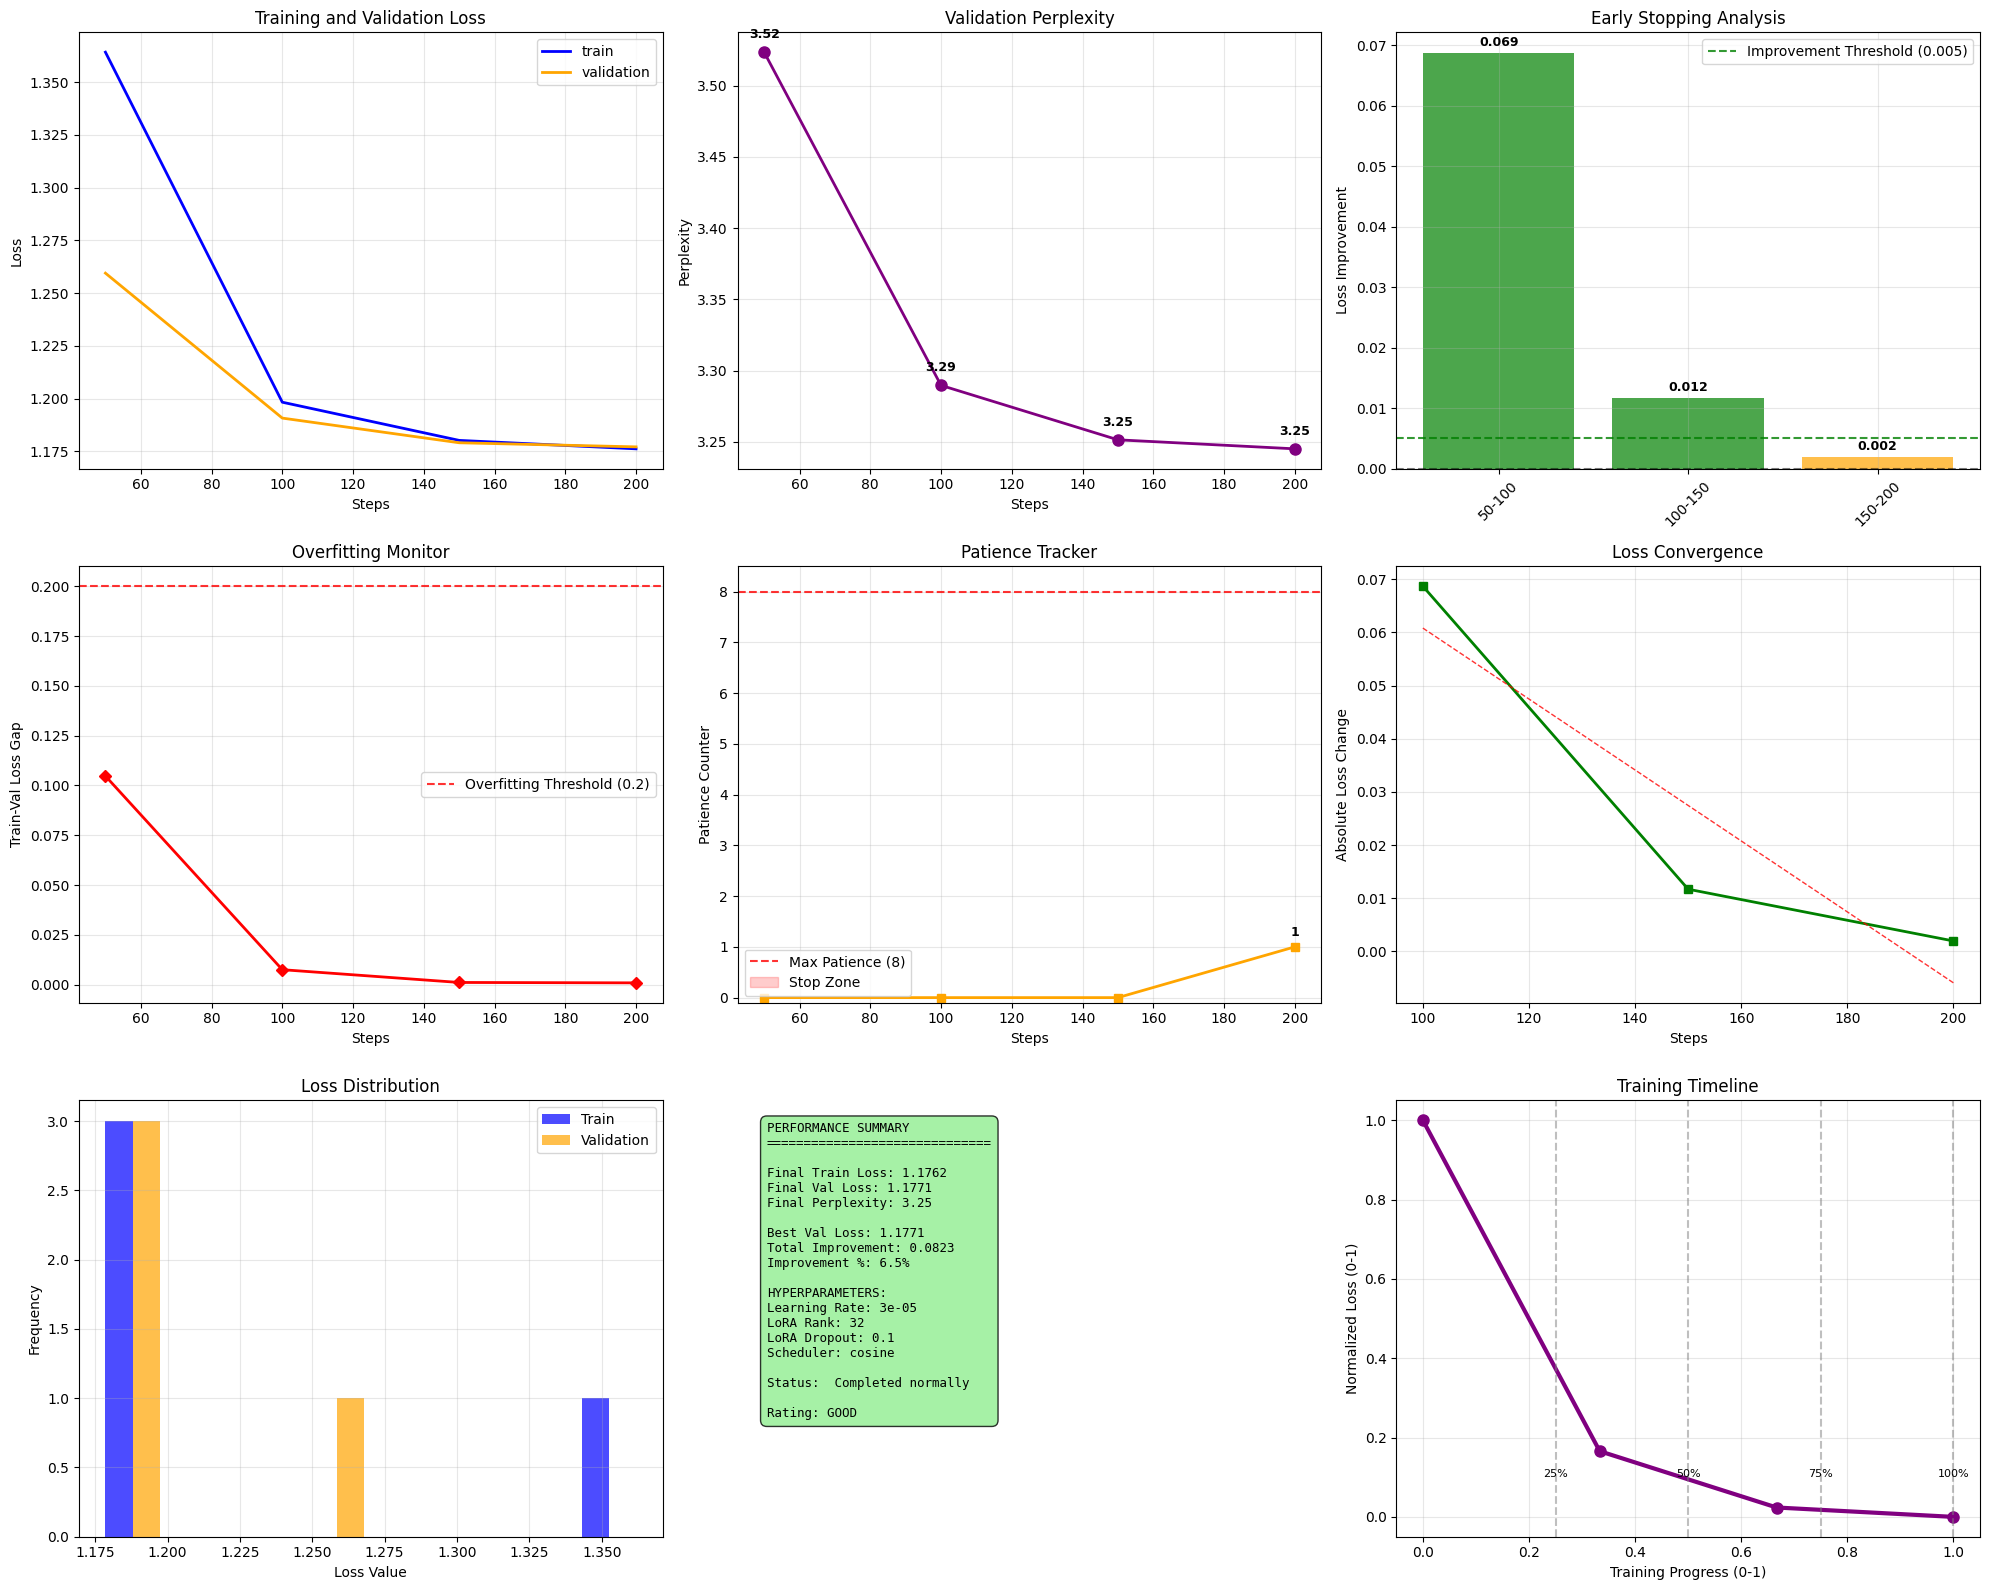


Training Data with Early Stopping Analysis:
Step | Training Loss | Validation Loss | Perplexity | Patience | Status
--------------------------------------------------------------------------------
 50  |    1.364200 |      1.259467 |     3.52 |       0 | 
100  |    1.198300 |      1.190765 |     3.29 |       0 | 
150  |    1.180200 |      1.179074 |     3.25 |       0 | 
200  |    1.176200 |      1.177125 |     3.25 |       1 | 

ENHANCED TRAINING SUMMARY WITH PARAMETER TUNING
HYPERPARAMETERS:
- Learning Rate: 3e-05
- LR Scheduler: cosine
- Warmup Ratio: 0.05
- Weight Decay: 0.001
- LoRA Rank: 32
- LoRA Alpha: 64
- LoRA Dropout: 0.1
- Gradient Accumulation: 4
- Max Grad Norm: 1.0

FINAL METRICS:
- Final Training Loss: 1.1762
- Final Validation Loss: 1.1771
- Final Perplexity: 3.25
- Best Validation Loss: 1.1771
- Best Perplexity: 3.25

EARLY STOPPING STATUS:
- Stopped Early: No
- Total Steps: 200
Enhanced training completed! All outputs saved to: /content/drive/MyDrive/research/mindsp

In [ ]:
# @title Run Training Pipeline

if __name__ == "__main__":
    # Set random seeds for reproducibility
    random.seed(42)
    np.random.seed(42)
    torch.manual_seed(42)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(42)

    # Print system info
    print(f"CUDA available: {torch.cuda.is_available()}")
    if torch.cuda.is_available():
        print(f"GPU: {torch.cuda.get_device_name(0)}")
        print(f"GPU Memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.1f} GB")

    # Print configuration summary
    print(f"\n ENHANCED CONFIGURATION SUMMARY:")
    print(f"   • Learning Rate: {LEARNING_RATE} ({LR_SCHEDULER_TYPE} scheduler)")
    print(f"   • LoRA: r={LORA_R}, α={LORA_ALPHA}, dropout={LORA_DROPOUT}")
    print(f"   • Early Stopping: patience={EARLY_STOPPING_PATIENCE}, threshold={EARLY_STOPPING_THRESHOLD}")
    print(f"   • Overfitting Detection: threshold={OVERFITTING_THRESHOLD}")
    print(f"   • Benefits: Better convergence, reduced overfitting, time savings")

    # Run enhanced training
    main()

In [ ]:
# @title Test Trained Model

try:
    test_cases = [
        "I feel really anxious about my upcoming job interview",
        "I'm struggling with depression and feel hopeless",
        "My relationship is falling apart and I don't know what to do",
        "I can't sleep at night because of all my worries",
        "I feel like I'm not good enough at anything I do"
    ]
    test_model(OUTPUT_DIR, test_cases)
except Exception as e:
    print(f"Testing Error: {e}")


loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--meta-llama--Llama-2-7b-chat-hf/snapshots/f5db02db724555f92da89c216ac04704f23d4590/config.json
Model config LlamaConfig {
  "architectures": [
    "LlamaForCausalLM"
  ],
  "attention_bias": false,
  "attention_dropout": 0.0,
  "bos_token_id": 1,
  "dtype": "bfloat16",
  "eos_token_id": 2,
  "head_dim": 128,
  "hidden_act": "silu",
  "hidden_size": 4096,
  "initializer_range": 0.02,
  "intermediate_size": 11008,
  "max_position_embeddings": 4096,
  "mlp_bias": false,
  "model_type": "llama",
  "num_attention_heads": 32,
  "num_hidden_layers": 32,
  "num_key_value_heads": 32,
  "pretraining_tp": 1,
  "rms_norm_eps": 1e-05,
  "rope_scaling": null,
  "rope_theta": 10000.0,
  "tie_word_embeddings": false,
  "transformers_version": "4.56.1",
  "use_cache": true,
  "vocab_size": 32000
}

loading weights file model.safetensors from cache at /root/.cache/huggingface/hub/models--meta-llama--Llama-2-7b-chat-

🧪 Testing fine-tuned model...
Loading model from: /content/drive/MyDrive/research/mindspace/final_model


target_dtype {target_dtype} is replaced by `CustomDtype.INT4` for 4-bit BnB quantization


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

All model checkpoint weights were used when initializing LlamaForCausalLM.

All the weights of LlamaForCausalLM were initialized from the model checkpoint at meta-llama/Llama-2-7b-chat-hf.
If your task is similar to the task the model of the checkpoint was trained on, you can already use LlamaForCausalLM for predictions without further training.
loading configuration file generation_config.json from cache at /root/.cache/huggingface/hub/models--meta-llama--Llama-2-7b-chat-hf/snapshots/f5db02db724555f92da89c216ac04704f23d4590/generation_config.json
Generate config GenerationConfig {
  "bos_token_id": 1,
  "do_sample": true,
  "eos_token_id": 2,
  "max_length": 4096,
  "pad_token_id": 0,
  "temperature": 0.6,
  "top_p": 0.9
}

loading file tokenizer.model
loading file tokenizer.json
loading file added_tokens.json
loading file special_tokens_map.json
loading file tokenizer_config.json
loading file chat_template.jinja


 Model loaded successfully!


--- Test Case 1 ---
 Client: I feel really anxious about my upcoming job interview
Therapist: It sounds like you have some pretty good reasons to be feeling nervous . Job interviews can definitely be nervewracking even if youve had many before ! I would suggest practicing answering questions in front of friends, family members, or other people who will give you feedback - this way it feels more realistic than just thinking about how you might answer questions .

--- Test Case 2 ---
 Client: I'm struggling with depression and feel hopeless
Therapist: It sounds like you may be experiencing some pretty intense feelings . I am sorry about this . It can also seem very difficult to get out of these types of feelings because we tend to become so used to feeling bad in general .

--- Test Case 3 ---
 Client: My relationship is falling apart and I don't know what to do
Therapist: It sounds like there may be some issues in this relationship . It can sometimes be dif